# Assignment 1 for FIT5212, Semester 1, 2020

**Student Name:**  Sarat Chandra Karasala

**Student ID:**    30098831

### Recommender System

In [35]:
import pandas as pd
import numpy as np
import surprise
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
from surprise import Reader, Dataset, SVD, KNNBasic, SVDpp
from surprise.model_selection import cross_validate, train_test_split
reader = Reader(rating_scale = (0,1))

#### Reading in all the files

In [36]:
itemFeatures = pd.read_csv('item_fea.csv')
links = pd.read_csv('links.csv')
testData = pd.read_csv('test_data.csv')
trainData = pd.read_csv('train_data.csv')
userFeatures = pd.read_csv('user_fea.csv')
validationData = pd.read_csv('validation_data.csv')

### Training Data

#### Checking the training data for duplicates NULLs and counting uniue values

In [37]:
print('Any duplicates?')
print(trainData.duplicated().value_counts())
print('\n')
print('How many uniue values does each columns have?')
print(trainData.nunique())
print('\n')
print('Are there any NULLs?')
print(trainData.isnull().sum(axis = 0))

trainData.head()

Any duplicates?
False    28449
dtype: int64


How many uniue values does each columns have?
user_id    2239
item_id    2174
rating        1
dtype: int64


Are there any NULLs?
user_id    0
item_id    0
rating     0
dtype: int64


,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


#### From the above and below cells we see that there are

*  2239 users with IDs from 0 to 2238
*  2174 items with IDs from 0 to 2173
*  All the ratings in this file are 1

In [38]:
trainData.describe()

,user_id,item_id,rating
count,28449.000000,28449.000000,28449.0
mean,1125.509438,972.367886,1.0
std,642.557518,614.678500,0.0
min,0.000000,0.000000,1.0
25%,571.000000,436.000000,1.0
50%,1124.000000,931.000000,1.0
75%,1688.000000,1481.000000,1.0
max,2238.000000,2173.000000,1.0


### Validation Data

#### Similar checking on validation data

In [39]:
print('Any duplicates?')
print(validationData.duplicated().value_counts())
print('\n')
print('How many uniue values does each columns have?')
print(validationData.nunique())
print('\n')
print('Are there any NULLs?')
print(validationData.isnull().sum(axis = 0))

validationData.head()

Any duplicates?
False    218975
True       4925
dtype: int64


How many uniue values does each columns have?
user_id    2239
item_id    2174
rating        2
dtype: int64


Are there any NULLs?
user_id    0
item_id    0
rating     0
dtype: int64


,user_id,item_id,rating
0,0,43,1
1,0,1102,0
2,0,815,0
3,0,739,0
4,0,1637,0


#### From the above and below cells we see that there are

*  4925 duplicates. We can leave them because they represent multiple interactions and could means a stronger relationship
*  This dataset also has 0 ratings along with 1

In [40]:
validationData.describe()

,user_id,item_id,rating
count,223900.000000,223900.000000,223900.000000
mean,1119.000000,1084.949410,0.010000
std,646.345005,627.237775,0.099499
min,0.000000,0.000000,0.000000
25%,559.000000,541.000000,0.000000
50%,1119.000000,1084.000000,0.000000
75%,1679.000000,1628.000000,0.000000
max,2238.000000,2173.000000,1.000000


#### Checking the number of 0s and 1s in rating

In [41]:
print(validationData['rating'].value_counts())

0    221661
1      2239
Name: rating, dtype: int64


#### We can just combine the two data sets and use then to train our model

In [42]:
trainValData = trainData.append(validationData, ignore_index = True)

#### We now have a large data set for training

In [43]:
trainValData['rating'].value_counts()

0    221661
1     30688
Name: rating, dtype: int64

### Test Data

#### Now let's check the testing data

In [44]:
print('Any duplicates?')
print(testData.duplicated().value_counts())
print('\n')
print('How many uniue values does each columns have?')
print(testData.nunique())
print('\n')
print('Are there any NULLs?')
print(testData.isnull().sum(axis = 0))

testData.head()

Any duplicates?
False    218851
True       5049
dtype: int64


How many uniue values does each columns have?
user_id    2239
item_id    2174
dtype: int64


Are there any NULLs?
user_id    0
item_id    0
dtype: int64


,user_id,item_id
0,0,2158
1,0,2113
2,0,2070
3,0,2026
4,0,1948


#### This is a list of all 2239 users each with a 100 items. We must use the user item interaction data to generate a top ten list of items for each user from their list of 100 items.

### User Item Interactions

*  We have a dataframe with the user item interations
*  Each row has a user ID, item ID and the 3rd column has a 0 if the user has never interacted with the item and 1 if the user has interacted
*  In the code below we generate a sparse matrix containing the user item interactions

In [45]:
userItemMatrix = sparse.csr_matrix((trainValData['rating'].astype(float), 
                                    (trainValData['user_id'], trainValData['item_id'])))

#### We have 2239 users and 2174 items

*  The shape of the matrix is obviously given by (user x item)
*  This matrix has more than 4.8 million values but only 247,424 values are non zero
*  Hence the name sparse matrix - most values are 0

In [46]:
userItemMatrix

<2239x2174 sparse matrix of type '<class 'numpy.float64'>'
	with 247424 stored elements in Compressed Sparse Row format>

#### α - Parameter

*  α is a parameter we use to give some worth or value to an interaction between a user and an item
*  It acts as a multiplier that scales the number of interactions linearly

In [47]:
alpha = 15
data = (userItemMatrix * alpha).astype('double')

In [48]:
# data[1,:].todense()

## Matrix Factorization

*  Matrix factorization is a popular algorithm used in recommender systems. The main data involved here is the user item interactions. It is a matrix showing the different ratings given by users to different items. This matrix is decomposed in to two factors. These smaller matrices introduce a new factor or latent variable.

*  We can call this latent variable a genre. The first matrix is a user feature matrix. Each row of the matrix represents how interested the user is in each genre. The second matrix is the item features. This matrix shows how each item is related to each genre.

## LMF

* The most commonly used optimization method is minimizing the RMSE. The method we're trying first is Logistic Matrix Factorizstion

*  LMF takes a probabilistic approach. The probability of a user interacting with a new item is predicted using a logistic function parametrized by the dot product of the user and item vectors.

*  The LMF function by implicit can return a list of recommendations for the users sorted in the order of decreasing probability

In [49]:
modelLMF = implicit.lmf.LogisticMatrixFactorization(factors = 8, regularization = 0.5, iterations = 300)
modelLMF.fit(data, show_progress = True)

#### Generating the User and Item vectors

In [16]:
userVectorsLMF = sparse.csr_matrix(modelLMF.item_factors)
itemVectorsLMF = sparse.csr_matrix(modelLMF.user_factors)

## ALS

*  Another optimization method is minimising the mean square error. But the mean square error here has two unknown variables. The user and item features.

*  Fixing one and optimizing the other makes this a simple linear regression problem.
*  ALS is a two step iterative process where in every iteration the user variable is fixed and the item variable is optimized and then the other way round.

In [26]:
modelALS = implicit.als.AlternatingLeastSquares(factors = 8, regularization = 0.1, iterations = 300)
modelALS.fit(data, show_progress = True)

#### Generating the User and Item vectors

In [27]:
userVectorsALS = sparse.csr_matrix(modelALS.item_factors)
itemVectorsALS = sparse.csr_matrix(modelALS.user_factors)

### Function to recommend items to a given user

#### How are we recommending items to users?

*  Get the user interactions for all the items for a given user
*  Adding 1 to everything to make 0s 1s
*  Make all values greater than 1 to 0
*  A dot product of the user and item vectors generates the recommended items
*  These item ID's are sorted and the top 10 items that are available in the given test list will be chosen

In [28]:
def recommend(userID, userItemMatrix, userVectors, itemVectors, numRec = 800):
    
    # Get the interactions of the current user from the user-item sparse matrix
    userInteractions = userItemMatrix[userID,:].toarray()
    
    # Add 1 to every element, so that articles with no interaction yet become 1
    userInteractions = userInteractions.reshape(-1) + 1
    
    # Change items that have already been interacted to 0
    userInteractions[userInteractions > 1] = 0
    
    # Get the dot product of the user vector and all the item vectors
    recVector = userVectors[userID,:].dot(itemVectors.T).toarray()
    
    # The resulting values are boundless
    # We need to scale them down to between 0 and 1
    minMax = MinMaxScaler()
    recVectorScaled = minMax.fit_transform(recVector.reshape(-1,1))[:,0]
    
    # Since we changed all the interacted content to 0 above their recommendation will be multiplied by zero
    # This makes sure we dont recommend a user an item that he/she has already used
    recommendVector = userInteractions * recVectorScaled
    
    # Sort the indices of the content into an order of best recommendations
    contentIdx = np.argsort(recommendVector)[::-1][:numRec]
    
    # Start empty lists to store the item IDs and scores
    titles = []
    scores = []

    for idx in contentIdx:
        titles.append(idx)
        scores.append(recommendVector[idx])

    recommendations = pd.DataFrame({'item_id': titles, 'score': scores})

    return recommendations

### Setting up

*  Generate a list of users

In [29]:
users = list(range(trainValData['user_id'].nunique()))

#### Recommendation Filter

*  Using the recommend function we generate 800 recommendations for each user.
*  We have been given a list of users with 100 items each
*  We are supposed to recommend items that are on the list
*  So we check if each recommended item is in the given test list before adding it to our final recommendation
*  We keep going untill we have 10 recommendations for each user before moving to the next

In [30]:
def listFilter(itemList, testItemList):
    
    filteredList = [item for item in itemList if item in testItemList]
    
    return filteredList[0:10]

#### The following code -

*  Loops through the user list
*  For every user it generates a list of 800 recommendations
*  From the test data it extracts the current user's 100 items
*  It then loops through the 800 items checking if each on is in those 100 items
*  If it is available in the test list we add it to the recommendation list
*  This filtered list is returned by the listFilter function above and the output is stored in a 2D list

### LMF

In [31]:
# Initializing counters and an empty list for storing the user ID and item IDs for the final recommendation list
count = 0
i = 0
outputLMF = [0] * (trainValData['user_id'].nunique() * 10)

# Looping through the user list generating 10 recommendations for each user
for user in users:
    
    # Recommending the top 800 items for each user
    temp = recommend(user, userItemMatrix, userVectorsLMF, itemVectorsLMF)
    
    # Store the recommended item IDs in a list
    itemList = temp['item_id'].to_list()
    
    # Get the list of items for each user from the test data set
    testItemList = testData[testData['user_id'] == user]['item_id'].to_list()
        
    # Filter the recommended items based on the items in the test data set and return the top 10 items
    filteredList = listFilter(itemList, testItemList)

    # Store the recommendations for  each user in the list defined above
    for item in filteredList:
        
        outputLMF[i] = [user, item]
        i = i + 1

        


### ALS

In [32]:
# Initializing counters and an empty list for storing the user ID and item IDs for the final recommendation list
count = 0
i = 0
outputALS = [0] * (trainValData['user_id'].nunique() * 10)

# Looping through the user list generating 10 recommendations for each user
for user in users:
    
    # Recommending the top 800 items for each user
    temp = recommend(user, userItemMatrix, userVectorsALS, itemVectorsALS)
    
    # Store the recommended item IDs in a list
    itemList = temp['item_id'].to_list()
    
    # Get the list of items for each user from the test data set
    testItemList = testData[testData['user_id'] == user]['item_id'].to_list()
    
    # Filter the recommended items based on the items in the test data set and return the top 10 items
    filteredList = listFilter(itemList, testItemList)

    # Store the recommendations for  each user in the list defined above    
    for item in filteredList:
        
        outputALS[i] = [user, item]
        i = i + 1

        


#### Output contains 10 recommendations for each of the 2239 users

In [33]:
outputLMF = pd.DataFrame(outputLMF, columns = ['user_id', 'item_id'])

# outputLMF.to_csv('outputLMF.csv', index = False)

#### Writing the output to a dataframe and then to a file that will be submitted

In [34]:
outputALS = pd.DataFrame(outputALS, columns = ['user_id', 'item_id'])

outputALS.to_csv('30098831.csv', index = False)

#### The above output file will be uploaded to kaggle

#### The maximum efficiency for the LMF approach is 16.8%

#### The maximum efficiency for the ALS approach is 21.4%

# Part 2

## Graph Clustering

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)
import torch
torch.manual_seed(0)

In [2]:
import networkx
import seaborn as sns
import matplotlib.pyplot as plt
from node2vec import Node2Vec

from nltk.corpus import stopwords
import re
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#### Reading the files

In [3]:
with open('A2 graph data\\docs.txt', encoding="utf8") as docsFileHandle:
  docList = docsFileHandle.readlines()

In [4]:
with open('A2 graph data\\labels.txt') as labelsFileHandle:
  labelList = labelsFileHandle.readlines()

In [5]:
with open('A2 graph data\\adjedges.txt') as adjFileHandle:
  adjEdgList = adjFileHandle.readlines()

#### Reading the lines from the file adjedges into a list

In [6]:
# Splitting each line in the text file by space delimiter and creating a list of lists
adjacentList = [i.split() for i in adjEdgList] 

#### This list now has the adjacent nodes for each node

*  The first node in each item of the list is the primary node and every node next to it is it's adjacent node
*  In the following cells we split the adjacent list into two list
*  One is a single node list and the other is a connected node list

In [7]:
# Empty lists to store the nodes with links in one and nodes with no links in another
linkedNodeList = []
nodeList = []

# Spliting each item in the adjacent list based on whether it is a single noded or a connected node
for each in adjacentList:
    
    # If the length of the list is more than 1 it is a connected node
    if len(each) != 1:        
        linkedNodeList.append(each)
        
    else:        
        nodeList.append(each[0])

#### Creating an edge list

*  In the following cells we unpack the above adjacent list and create an edge list

In [8]:
# Empty edge list
edges = []

# Loop through each of the linked node list and unpack the edges
for i in range(len(linkedNodeList)):
    
    # If the item in index i has n nodes, the first node is the centre and the nodes 2 to n-1 are its adjacent nodes
    # So we create tuples with 2 items. The centre node and one of the adjacent nodes
    for j in range(len(linkedNodeList[i]) - 1):
        edge = (linkedNodeList[i][0], linkedNodeList[i][j+1])
        edges.append(edge)

#### We need a dataframe with each edge and the first node's classification label

* First we create a dataframe with the edge list. It has 2 columns node01 and node02
* Then create a dataframe from the label doc which gives use two columns node01 and label
* Merge these two columns 'on' 'node01'

In [9]:
edgeDF = pd.DataFrame.from_records(edges, columns = ['node01', 'node02']) 

In [10]:
newLabelList = [i.split() for i in labelList]
labelDF = pd.DataFrame.from_records(newLabelList, columns = ['node01', 'label']) 

In [11]:
edgeLabelDF = edgeDF.merge(labelDF, how = 'inner', on = 'node01')

### Creating a Graph

*  Initialize an empty graph
* Add nodes from the list created above
* Edge edges from the edge list

In [12]:
# Empty graph
docGraph = networkx.Graph()
# Adding nodes
docGraph.add_nodes_from(nodeList)
# Adding edges
docGraph.add_edges_from(edges)

#### Plotting the network graph gives us the below output - Cant tell anything from it

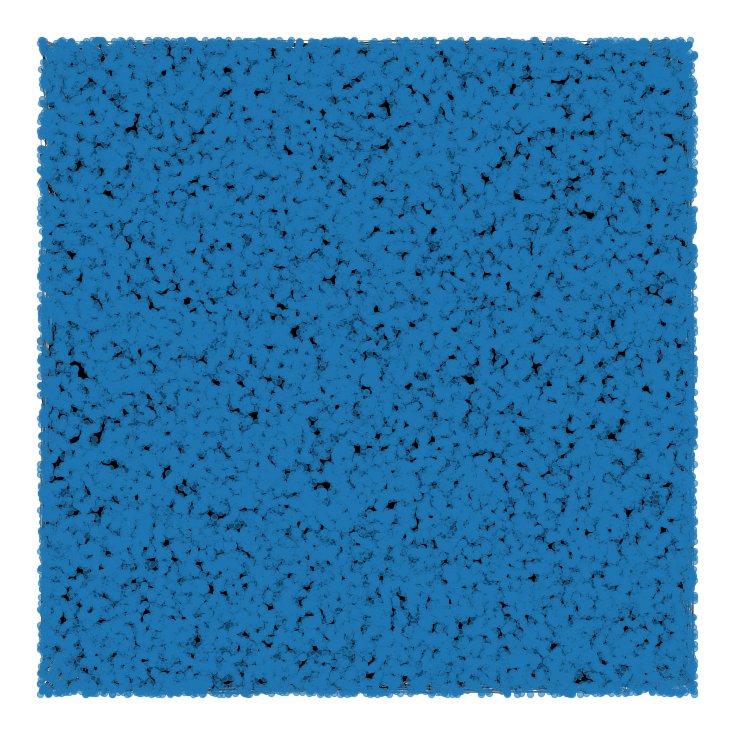

In [13]:
plt.figure(figsize=(10,10))

pos = networkx.random_layout(docGraph, seed=23)
networkx.draw(docGraph, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

## Graph Embedding Approach

## Node2Vec

*  Word2vec is a text embedding model. It takes as input a large corpus of text and returns vector representations of different words

*  Node2Vec does something similar with the nodes in a graph
*  Skip-Gram model basically takes a word and tries to predict the surrounding context words
*  Similarly for Node2Vec we use a random walk approach where we set the walk length and the number of random walks to take
*  Th algorithm then uses these walks to vectorize the nodes

In [14]:
node2vec = Node2Vec(docGraph, dimensions=30, walk_length=15, num_walks=50, workers=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [10:33<00:00, 12.66s/it]


In [15]:
model = node2vec.fit(window=30, min_count=1)

#### Now that we have generated feature vectors for all the nodes...

*  We need to combine the vector representations of both the nodes forming an edge
*  So we send each node to the model and concatenate the two nodes in the edge

In [16]:
x = [(model[str(i)]+model[str(j)]) for i,j in zip(edgeLabelDF['node01'], edgeLabelDF['node02'])]

D:\Software\Anaconda\envs\PythonR\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


#### Splitting the code into training and testing datasets

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), edgeLabelDF['label'], test_size = 0.8, random_state = 35)

#### With the training and testing datasets ready we can trying the standard machine learning algorithms

In [43]:
linSVCModel = LinearSVC(max_iter = 10000, C = 0.001).fit(xtrain, ytrain)

### Results - Node2Vec

In [46]:
predictions = linSVCModel.predict(xtest)
accuracy = accuracy_score(ytest, predictions)

print(confusion_matrix(ytest, predictions))
print('\nAccuracy')
print(accuracy)

[[  444   891     2  1437     0]
 [   54 23618    42  1803     0]
 [   22  2298    95  1118     0]
 [   61  2139    11  8359     4]
 [  109   374     0   800     0]]

Accuracy
0.7443968773608662


#### Confusion Matrix

*  The confusion matrix shows the number of documents classified or misclassified
*  In a confusion matrix the rows are the True values starting from 0 to 4 and the columns are the predicted values
*  Therefore this means the diagonal elements are the correctly classified items
*  We classified 0 nodes of label 4 correctly

#### The accuracy is 74%

## Text Classification Approach

#### We have the document titles on which we can perform text embedding and classification

*  Although the amount of text we have is very little it could help because the title has specific words that summarize what the document is about which is what is needed to classify the documents.

#### Initialize a Spacy Lemmatizer

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

class LemmaTokenizerSpacy(object):        
    def __call__(self,doc):
        trydoc = nlp(doc)
        return [token.lemma_ for token in trydoc]

#### Initialize a set of stop words from NLTK

In [22]:
stop_words_en = set(stopwords.words('english'))

#### Punctuations and Stopwords

*  We have very little text. So numbers and punctuations are not going to give us any extra info

In [23]:
# An empty list to store the cleaned up text
cleanDocList = []

# First we remove every character that is not an alphabet or a space
# Then we lower case all characters and remove the stop words
for each in docList:    
    temp = re.sub(r'[^a-zA-Z ]', ' ', str(each))    
    cleanDocList.append(' '.join([word for word in temp.lower().split() if word not in stop_words_en]))

#### A split operation on the doc list will split each line based on the space delimiter

*  The first element is always the node number
*  This node number is stored in the doc node list

In [24]:
docNodeList = []

for each in docList:    
    temp = each.split()    
    docNodeList.append(temp[0])

#### Using the clean document list and the document node list we get a data frame with the node (which acts as the ID) and the text (title)

In [25]:
nodeDocDF = pd.DataFrame(columns = ['node01', 'title'])

nodeDocDF['node01'] = docNodeList
nodeDocDF['title'] = cleanDocList

#### We join this node title dataframe with the label dataframe to get the dataset we need to work on

In [26]:
nodeDocLabDF = nodeDocDF.merge(labelDF, how = 'inner', on = 'node01')

#### This dataframe is ready for text classification

In [27]:
nodeDocLabDF.head()

,node01,title,label
0,12828558,assessing local institutional capacity data av...,0
1,66779408,prospects internet telephony europe latin amer...,0
2,38902949,economic shocks safety nets fiscal constraints...,0
3,33450563,reform growth poverty vietnam,0
4,57470294,households economic growth latin america carib...,0


#### Splitting into training and testing data sets

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(nodeDocLabDF, nodeDocLabDF['label'], test_size = 0.8, random_state = 35)

In [29]:
trainTitleList = xtrain['title'].tolist()
trainLabelList = xtrain['label'].tolist()

testTitleList = xtest['title'].tolist()
testLabelList = xtest['label'].tolist()

#### Initializing the TFIDF Vectorizer

In [30]:
TFIDFvec = TfidfVectorizer(analyzer = 'word',
                            input = 'content',
                            min_df = 1,
                            ngram_range = (1,2),
                            tokenizer = LemmaTokenizerSpacy())

#### Vectorizing the training and testing datasets

In [31]:
trainDocFeatures = TFIDFvec.fit_transform(trainTitleList)


In [32]:
testDocFeatures = TFIDFvec.transform(testTitleList)

#### Logistic Regression - Confusion Matrix

In [48]:
LRModel = LogisticRegression(max_iter = 5000).fit(trainDocFeatures, trainLabelList)

# prediction
predictions = LRModel.predict(testDocFeatures)

print(confusion_matrix(testLabelList, predictions))
    
    

accuracy = accuracy_score(testLabelList, predictions)


print('\nAccuracy: '+ str(accuracy))

[[4243   97  207   47   40]
 [ 273 2576  315   50    4]
 [ 637  245 2585   82    1]
 [ 309  130  303 1406    0]
 [ 752   42   99   18  515]]

Accuracy: 0.7562099358974359


#### Linear SVC - Confusion Matrix

In [47]:
LSVCModel = LinearSVC(max_iter=5000, C = 0.2).fit(trainDocFeatures, trainLabelList)

LSVCpredictions = LSVCModel.predict(testDocFeatures)

print(confusion_matrix(testLabelList, LSVCpredictions))

LSVCaccuracy = accuracy_score(testLabelList, LSVCpredictions)

print('\nAccuracy: '+ str(LSVCaccuracy))

[[4141  110  219   66   98]
 [ 214 2663  267   68    6]
 [ 570  278 2570  125    7]
 [ 225  154  236 1528    5]
 [ 629   44   94   24  635]]

Accuracy: 0.7703659188034188


#### Linear SVC (77%) performs better than Logistic Regression (75%) and both the methods are better than node2vec which is at 74%